In [23]:
from quasinet.qnet import qdistance, save_qnet
from cognet.cognet import cognet as cg
from cognet.dataFormatter import dataFormatter
from cognet.model import model 
#import cognet.util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [59]:
## read in data, configure to Qnet specifications and fit Qnet model
data_obj=dataFormatter(samples="data/PTSD_cognet_test_processed.csv")
features,samples = data_obj.Qnet_formatter()

In [3]:
fit = False
model_obj = model()
if fit:
    model_obj.fit(data_obj=data_obj, njobs=2)
    # model_obj.save("examples_results/PTSD_cognet_test.joblib")
    save_qnet(model_obj.myQnet, "results/PTSD_cognet_test.joblib", low_mem=False)
else:
    model_obj.load("results/PTSD_cognet_test.joblib")

In [4]:
from quasinet.qnet import Qnet, qdistance, load_qnet, qdistance_matrix
from quasinet.qsampling import qsample, targeted_qsample
#from mpi4py.futures import MPIPoolExecutor
import sys
import subprocess
from scipy.stats import entropy
import multiprocessing as mp
import time
from cognet.util import embed_to_pca
import pkgutil
import os

import numpy as np
import pandas as pd
import random

class cognet:
    """Aggregate related Qnet functions
    """

    def __init__(self):
        """Init
        """
        self.year = None
        self.n_jobs = 28
        self.qnet = None
        self.steps = 120
        self.num_qsamples = None
        self.all_samples = None
        self.samples = None
        self.samples_as_strings = None
        self.features = None
        self.cols = None
        self.immutable_vars = None
        self.mutable_vars = None
        self.poles = None
        self.polar_features = None
        self.polar_indices = None
        self.poles_dict = {}
        self.d0 = None
        self.s_null = None
        self.D_null = None
        self.mask_prob = 0.5
        self.variation_weight = None
        self.polar_matrix = None
        self.nsamples = None
        self.restricted = False
        self.MAX_PROCESSES = 0
    
    def load_from_model(self,
                        model,
                        data_obj,
                        key,
                        im_vars=None,
                        m_vars=None):
        """load parameters from model object

        Args:
          model (Class): model obj for loading parameters
          data_obj (class): instance of dataformatter class
          key (str): 'all', 'train', or 'test', corresponding to sample type
          im_vars (list[str], optional): Not implemented yet. Defaults to None.
          m_vars (list[str], optional): Not implemented yet. Defaults to None.
        """
        if model is not None:
            # inherit atrributes from model object
            self.qnet = model.myQnet
            featurenames, samples = data_obj.format_samples(key)
            samples = pd.DataFrame(samples)
            self.cols = np.array(featurenames)
            self.features = pd.DataFrame(columns=np.array(featurenames))
            
            # inherit mutable and immutable variables from model obj
            if any(x is not None for x in [model.immutable_vars, model.mutable_vars]):
                if model.immutable_vars is not None:
                    self.immutable_vars = model.immutable_vars
                    self.mutable_vars = [x for x in self.features if x not in self.immutable_vars]
                elif model.mutable_vars is not None:
                    self.mutable_vars = model.mutable_vars
                    self.immutable_vars = [x for x in self.features if x not in self.mutable_vars]
            else:
                self.mutable_vars = self.features
            
            # inherit and set class attributes.
            self.samples = pd.DataFrame(samples).replace("nan","").fillna("")
            self.samples.columns = np.array(featurenames)
            self.all_samples = self.samples
            self.samples_as_strings = self.samples.fillna('').values.astype(str)[:]
            self.s_null=['']*len(self.samples_as_strings[0])
            self.D_null=self.qnet.predict_distributions(self.s_null)
            variation_weight = []
            for d in self.D_null:
                v=[]
                for val in d.values():
                    v=np.append(v,val)
                variation_weight.append(entropy(v,base=len(v)))
            variation_weight = np.nan_to_num(variation_weight) # remove nans
            self.variation_weight = variation_weight
    
    def load_from_dataformatter(self, 
                                data_obj,
                                key):
        """read in either train or test data, specified by key, from data obj,
        and inherit other attributes.

        Args:
          data_obj (class): instance of dataformatter class
          key (str): 'all', 'train', or 'test', corresponding to sample type
          
        Returns:
          featurenames, samples: formatted arrays
        """
        # inherit attributes from dataformatter object
        featurenames, samples = data_obj.format_samples(key)
        if any(x is not None for x in [self.features, self.samples]):
            print("replacing original features/samples with dataformatter data")
        self.cols = featurenames
        self.features = pd.DataFrame(columns=self.cols)
        self.samples = pd.DataFrame(samples,columns=self.features)
        self.all_samples = self.samples
        self.samples_as_strings = self.samples[self.cols].fillna('').values.astype(str)[:]
        self.s_null=['']*len(self.samples_as_strings[0])
        return featurenames, samples

    def load_data(self,
                  year,
                  features_by_year,
                  samples,
                  Qnet):
        '''load cols, features, samples, and qnet.

        Args:
          year (str): to identify cols/features.
          features_by_year (str): file containing all features by year of the dataset.
          samples (str): file of samples for that year.
          Qnet (str): Qnet file location.
        '''
        # set attributes from given files and data
        self.qnet = load_qnet(qnet)
        self.year = year
        self.cols = np.array((pd.read_csv(features_by_year,
                            keep_default_na=True, 
                            index_col=0).set_index(
                                'year')).loc[int(year)].apply(
                                    eval).values[0])
        self.features = pd.DataFrame(columns=self.cols)
        self.mutable_vars = [x for x in self.cols]
        #[self.cols].fillna('').values.astype(str)[:]

        # read in samples and initialize related attributes
        self.samples=pd.read_csv(samples)
        self.samples = pd.concat([self.samples,self.features], axis=0)
        self.all_samples = self.samples
        self.samples_as_strings = self.samples[self.cols].fillna('').values.astype(str)[:]
        self.s_null=['']*len(self.samples_as_strings[0])
        self.D_null=self.qnet.predict_distributions(self.s_null)
        variation_weight = []
        for d in self.D_null:
            v=[]
            for val in d.values():
                v=np.append(v,val)
            variation_weight.append(entropy(v,base=len(v)))
        self.variation_weight = variation_weight

    def set_immutable_vars(self,
                        IMMUTABLE_FILE):
        '''set vars to immutable and mutable, 
        can prob combine this with the load_data func: only set the immutable vars if necessary

        Args:
          IMMUTABLE_FILE (str): file containing the immutable features/vars
        '''
        # set mutable and immutable variable attributes 
        if self.cols is None:
            raise ValueError("load_data first!")
        self.immutable_vars = pd.read_csv(IMMUTABLE_FILE,index_col=0).transpose()
        self.mutable_vars = None
        self.mutable_vars = [x for x in self.cols
                            if x.upper() not in self.immutable_vars.columns]
    
    def set_nsamples(self,
                    num_samples,
                    random=False):
        '''select a subset of the samples

        Args:
          num_samples (int): Set num of samples to subset, default to None, resets to all samples
          random (bool): take random sample if true, ordered sample if false
        '''
        # each time function is called, reset samples to use_all_samples
        # this allows us to call nsamples numerous times 
        self.samples = self.all_samples
        if self.samples is not None:
            # if a greater number of sample is selected than available, raise error
            if all(x is not None for x in [num_samples, self.samples]):
                if num_samples > len(self.samples.index):
                    string = 'The number of selected samples ({}) ' + \
                        'is greater than the number of samples ({})!'
                    string = string.format(num_samples, len(self.samples.index))
                    raise ValueError(string)

                # if the same number of samples is selected as available, print warning
                if num_samples == len(self.samples.index):
                    string = 'The number of selected samples ({}) ' + \
                        'is equal to the number of samples ({})!'
                    string = string.format(num_samples, len(self.samples.index))
                    print(string)
                    
                # if random is true, return random sample, otherwise return an ordered slice
                if random:
                    self.samples = self.samples.sample(num_samples)
                else:
                    self.samples = self.samples.iloc[:num_samples]
                self.nsamples = num_samples
                self.samples_as_strings = self.samples[self.cols].fillna('').values.astype(str)[:]
                
            elif self.samples is None:
                raise ValueError("load_data first!")

    def __variation_weight(self,
                        index):
        """
        """
        d_=self.D_null[index]
        v=[]
        for val in d_.values():
            v=np.append(v,val)
        return entropy(v,base=len(v))
    
    def getBaseFrequency(self, 
                        sample):
        '''get frequency of the variables
        helper func for qsampling

        Args:
          sample (list[str]): vector of sample, must have the same num of features as the qnet
        '''
        # if variable is not mutable, set its base frequency to zero 
        MUTABLE=pd.DataFrame(np.zeros(len(self.cols)),index=self.cols).transpose()
             
        for m in self.mutable_vars:
            MUTABLE[m]=1.0
        mutable_x=MUTABLE.values[0]
        base_frequency=mutable_x/mutable_x.sum()
        
        # otherwise, set base frequency weighted by variation weight
        for i in range(len(base_frequency)):
            if base_frequency[i]>0.0:
                base_frequency[i]= self.variation_weight[i]*base_frequency[i]

        return base_frequency/base_frequency.sum()
    
    def qsampling(self,
                sample,
                steps,
                immutable=False):
        '''perturb the sample based on thet qnet distributions and number of steps

        Args:
          sample (1d array-like): sample vector, must have the same num of features as the qnet
          steps (int): number of steps to qsample
          immutable (bool): are there variables that are immutable?
        '''
        # immutable, check that mutable variables have been initialized
        if immutable == True:
            if all(x is not None for x in [self.mutable_vars, sample]):
                return qsample(sample,self.qnet,steps,self.getBaseFrequency(self.samples))
            elif self.mutable_vars is None:
                raise ValueError("set mutable and immutable variables first!")
        else:
            return qsample(sample,self.qnet,steps)

    def random_sample(self,
                      df=None,
                      n=1):
        '''compute a random sample from the underlying distributions of the dataset, by column.
        
        
        Args:
          df (pandas.DataFrame): Desired data to take random sample of. Defaults to None, in which case qnet samples are used.
          n (int): number of random samples to take. Defaults to 1.
          
        Returns:
          return_df (pd.DataFrame): Random sample drawn from underlying distribution of each column.
        '''
        # check if a new dataset was inputted
        if df is None:
            samples_ = self.samples
        else:
            samples_ = df

        # take random sample from each of the columns based on their distribution
        return_df = pd.DataFrame()
        for col in samples_.columns:
            return_df[col] = samples_[col].sample(n=n, replace=True).values
            
        return return_df
    
    def set_poles(self,
                  POLEFILE,
                  pole_1,
                  pole_2,
                  steps=0,
                  mutable=False,
                  VERBOSE=False,
                  restrict=True,
                  nsamples = None,
                  random=False):
        '''set the poles and samples such that the samples contain features in poles

        Args:
          steps (int): number of steps to qsample
          POLEFILE (str): file containing poles samples and features
          pole_1 (str): column name for first pole
          pole_2 (str): column name for second pole
          mutable (bool): Whether or not to set poles as the only mutable_vars
          VERBOSE (bool): boolean flag prints number of pole features not found in sample features if True
          restrict (bool): boolean flag restricts the sample features to polar features if True
          random (bool): boolean flag takes random sample of all_samples
        '''
        invalid_count = 0
        if all(x is not None for x in [self.samples, self.qnet]):
            # read and set poles
            poles = pd.read_csv(POLEFILE, index_col=0)
            self.poles=poles.transpose()
            self.polar_features = pd.concat([self.features, self.poles], axis=0).fillna('')
            poles_dict = {}
            for column in poles:
                p_ = self.polar_features.loc[column][self.cols].fillna('').values.astype(str)[:]
                # qsample poles to qnet
                poles_dict[column] = self.qsampling(p_,steps)
            self.poles_dict = poles_dict
            self.pL = self.poles_dict[pole_1]
            self.pR = self.poles_dict[pole_2]
            self.d0 = qdistance(self.pL, self.pR, self.qnet, self.qnet)
            
            # restrict sample columns to polar columns
            if restrict:
                cols = [x for x in self.poles.columns if x in self.samples.columns]
                self.samples=self.samples[cols]
                self.restricted = True
                self.samples = pd.concat([self.features,self.samples], axis=0).replace("nan","").fillna('')
                self.samples_as_strings = self.samples[self.cols].fillna('').values.astype(str)[:]
                
            # if restrict==False, unrestrict it and set original
            else:
                self.restricted = False
                self.samples = self.all_samples
                if self.nsamples is not None:
                    self.set_nsamples(nsamples, random)
            
            # identify pole features that were excluded due to sample features restriction
            if VERBOSE:
                for x in self.poles.columns:
                    if x not in self.samples.columns:
                        invalid_count += 1
                        #self.samples[x]=''
            
            if mutable:
                self.mutable_vars=[x for x in self.cols if x in self.poles.columns]
        elif self.samples is None:
            raise ValueError("load_data first!")

        if VERBOSE:
            print("{} pole features not found in sample features".format(invalid_count))

    def mp_compute(self, 
                   processes,
                   func, 
                   cols,
                   outfile, 
                   args=[]):
        """
        Compute desired function through multiprocessing and save result to csv.

        Args:
          processes (int): number of processes to use.
          func (func): function to compute using multiprocessing
          cols (list): column names of resulting csv
          outfile (str)): filepath + filename for resulting csv
          args (list): list containing arguments for desired function. Defaults to empty list.
        """

        # init mp.Manager and result dict
        manager = mp.Manager()
        return_dict = manager.dict()

        # set processes as given, unless class parameter is set
        max_processes = processes
        if self.MAX_PROCESSES != 0:
            max_processes = self.MAX_PROCESSES
            print("Number of Processes {} has been set using class parameter".format(self.MAX_PROCESSES))
        num_processes = 0
        process_list = []
        
        # init mp.Processes for each individual sample
        # run once collected processes hit max
        for i in range(len(self.samples)):
            params = tuple([i, return_dict] + args)
            num_processes += 1
            p = mp.Process(target=func,
                        args=params)
            process_list.append(p)
            if num_processes == max_processes:
                [x.start() for x in process_list]
                [x.join() for x in process_list]
                process_list = []
                num_processes = 0
                
        # compute remaining processes
        if num_processes != 0:
            [x.start() for x in process_list]
            [x.join() for x in process_list]
            process_list = []
            num_processes = 0
        
        # format and save resulting dict
        result = pd.DataFrame(return_dict.values(), columns=cols, index=return_dict.keys()).sort_index()
        result.to_csv(outfile, index=None)
        return result
    
    def distance(self,
                sample1,
                sample2,
                nsteps1=0,
                nsteps2=0):
        """qsamples each sample set num of steps, then takes qdistance

        Args:
          sample1 (list[str]): sample vector 1, must have the same num of features as the qnet
          sample2 (list[str]): sample vector 2, must have the same num of features as the qnet
          nsteps1 (int, optional): number of steps to qsample for sample1
          nsteps2 (int, optional): number of steps to qsample for sample2

        Returns:
          qdistance: float, distance between two samples
        """
        if self.qnet is None:
            raise ValueError("load qnet first!")
        #bp1 = self.getBaseFrequency(sample1)
        #bp2 = self.getBaseFrequency(sample2)
        # qsample samples
        sample1 = qsample(sample1, self.qnet, nsteps1)#, baseline_prob=bp1)
        sample2 = qsample(sample2, self.qnet, nsteps2)#, baseline_prob=bp2)
        return qdistance(sample1, sample2, self.qnet, self.qnet)
    
    def __distfunc(self, 
                   x, 
                   y):
        '''Compute distance between two samples

        Args:
          x (list[str]): first sample
          y (list[str]): second sample
          
        Returns:
         d: qdistance
        '''
        d=qdistance(x,y,self.qnet,self.qnet)
        return d
    
    def distfunc_line(self,
                    i,
                    return_dict=None):
        '''compute the distance for a single sample from all other samples

        Args:
          i (int): row
          return_dict (dict): dictionary containing multiprocessing results
        
        Return:
          line: float, numpy.ndarray
        '''
        if all(x is not None for x in [self.samples, self.features]):
            w = self.samples.index.size
            line = np.zeros(w)
            y = self.samples_as_strings[i]
            for j in range(w):
                # only compute half of the distance matrix
                if j > i:
                    x = self.samples_as_strings[j]
                    line[j] = self.__distfunc(x, y)
        else:
            raise ValueError("load_data first!")
        if return_dict is not None:
            return_dict[i] = line
        return line
    
    def distfunc_multiples(self,
                           outfile,
                           processes=6):
        """compute distance matrix for all samples in the dataset

        Args:
          outfile (str): desired output filename and path
          
        Returns:
          result: pandas.DataFrame containing distance matrix
        """
        if all(x is not None for x in [self.samples, self.features]):
            cols = [i for i in range(len(self.samples))]
            result = self.mp_compute(processes,
                                        self.distfunc_line,
                                        cols,
                                        outfile)
            # format and save resulting dict, and tranpose symmetrical distance matrix
            result = result.to_numpy()
            result = pd.DataFrame(np.maximum(result, result.transpose()))
            result.to_csv(outfile, index=None, header=None)
        else:
            raise ValueError("load data first!")
        
        return result
    
    def polarDistance(self,
                    i,
                    return_dict=None):
        """return the distances from a single sample to the poles

        Args:
          i (int): index of sample to take
          return_dict (dict): dictionary containing multiprocessing results

        Returns:
          distances: float, distance from sample to each pole
        """
        p = self.samples_as_strings[i]
        distances = []
        # calculate from each pole to the sample, and append to array
        for index, row in self.polar_features[self.cols].iterrows():
            row = row.fillna('').values.astype(str)[:]
            distances.append(self.distance(p, np.array(row)))
        if return_dict is not None:
            return_dict[i] = distances
        return distances
            
    def polarDistance_multiple(self,
                               outfile,
                               processes=6):
        """return the distance from all samples to the poles

        Args:
          outfile (str): desired output filename and path
          
        Returns:
          result: pandas.DataFrame containing polar distance results
        """
        if all(x is not None for x in [self.samples, self.cols,
                                    self.polar_features]):
            # get the column names
            pole_names = []
            for index, row in self.polar_features[self.cols].iterrows():
                pole_names.append(index)
            result = self.mp_compute(processes,
                                        self.polarDistance,
                                        pole_names,
                                        outfile)
        else:
            raise ValueError("load data first!")
        return result
    
    def polar_separation(self,
                        nsteps=0):
        """calculates the distance between poles as a qdistance matrix

        Args:
          nsteps (int, optional): [description]. Defaults to 0.
          
        Returns:
          self.polar_matrix: dictionary containing multiprocessing results
        """
        # vectorize and qsample poles
        polar_arraydata = self.polar_features[self.cols].values.astype(str)[:]
        samples_ = []
        for vector in polar_arraydata:
            bp = self.getBaseFrequency(vector)
            sample = qsample(vector, self.qnet, nsteps, baseline_prob=bp)
            samples_.append(sample)
        samples_ = np.array(samples_)
        # calculate distance matrix for poles
        self.polar_matrix = qdistance_matrix(samples_, samples_, self.qnet, self.qnet)
        return self.polar_matrix
        
    def embed(self,
            infile,
            name_pref,
            out_dir,
            pca_model=False,
            EMBED_BINARY=None):
        '''
        embed data

        Args:
          infile (str): input file to be embedded
          name_pref (str): preferred name for output file
          out_dir (str): output dir for results
          pca_model (bool): whether or not to generate PCA model
          EMBED_BINARY (os.path.abspath): path to embed binary
        '''
        if all(x is not None for x in [self.year]):
            # init file names 
            yr = self.year
            PREF = name_pref
            FILE = infile
            DATAFILE = out_dir + 'data_' +yr
            EFILE = out_dir + PREF + '_E_' +yr
            DFILE = out_dir + PREF + '_D_' +yr
            
            # set embed binary directory
            if EMBED_BINARY is None:
                EMBED = pkgutil.get_data("cognet.bin", "__embed__.so") 
            else:
                EMBED = EMBED_BINARY
            
            # embed data files
            pd.read_csv(FILE, header=None).to_csv(DATAFILE,sep=' ',header=None,index=None)
            STR=EMBED+' -f '+DATAFILE+' -E '+EFILE+' -D '+DFILE
            subprocess.call(STR,shell=True)
            if pca_model:
                embed_to_pca(EFILE, EFILE+'_PCA')
        elif self.year is None:
            raise ValueError("load_data first!")
    
    def __calc_d0(self,
                pole_1,
                pole_2):
        """calculate distance between two poles

        Args:
          pole_1 (list[str]): a polar vector, must have same number of features as qnet
          pole_2 (list[str]): a polar vector, must have same number of features as qnet
        """
        self.pL = self.poles_dict[pole_1]
        self.pR = self.poles_dict[pole_2]
        self.d0 = qdistance(self.pL, self.pR, self.qnet, self.qnet)
        
    def ideology(self,
                i,
                return_dict=None,
                pole_1=None,
                pole_2=None):
        """return ideology index (left-leaning or right-leaning) for a singular sample

        Args:
          i (int): index of sample
          pole_1 (int): index of Pole One to calc as base distance. Defaults to 0.
          pole_2 (int): index of Pole Two to calc as base distance. Defaults to 1.
          return_dict (dict, optional): dict containing results
          
        Returns:
          [ideology_index, dR, dL, self.d0]: which way the sample leans,
                                             distance from the right pole,
                                             distance from the left pole,
                                             and distance between poles, respectively
        """
        # calculate base distance between two poles
        if pole_1 is not None or pole_2 is not None:
            self.__calc_d0(pole_1, pole_2)
        
        # calculate distances between sample and the two poles
        p = self.samples_as_strings[i]
        dR = qdistance(self.pR, p, self.qnet, self.qnet)
        dL = qdistance(self.pL, p, self.qnet, self.qnet)
        
        ideology_index = (dR-dL)/self.d0
        if return_dict is not None:
            return_dict[i] = [ideology_index, dR, dL, self.d0]
        return [ideology_index, dR, dL, self.d0]

    def dispersion(self,
                   i,
                   return_dict=None):
        """qsamples a sample n times and takes distance matrix 
        to determine max and std of distances between qsamples

        Args:
          i (int): index of sample
          return_dict (dict): dictionary containing multiprocessing results

        Returns:
          list[float]: std and max of the distances btwn qsamples
        """
        # qsample sample num_qsample times
        p = self.samples_as_strings[i]
        Qset = [qsample(p, self.qnet, self.steps) for j in np.arange(self.num_qsamples)]
        Qset = np.array(Qset)

        # calculate qdistance matrix for qsampled samples
        matrix = (qdistance_matrix(Qset, Qset, self.qnet, self.qnet))
        Q = matrix.max()
        Qsd = matrix.std()
        
        if return_dict is not None:
            return_dict[i] = [Qsd, Q]
        return [Qsd, Q]
    
    def compute_DLI_samples(self,
                        type,
                        outfile,
                        num_qsamples=40,
                        steps=120,
                        n_jobs=28,
                        pole_1=0,
                        pole_2=1,
                        processes=6):
        """compute and save ideology index or dispersion for all samples

        Args:
          num_qsamples (int): number of qsamples to compute
          outfile (str): output file for results
          type (str): whether to calc dispersion or ideology
          steps (int): number of steps to qsample
          n_jobs (int, optional): sets the number of jobs for parallelization. Defaults to 28.
          pole_1 (int, optional): index of Pole One to calc as base distance. Defaults to 0.
          pole_2 (int, optional): index of Pole Two to calc as base distance. Defaults to 1.

        Raises:
          ValueError: set poles if poles are not set
          ValueError: load data if samples or features are not present
            
        Returns:
          result: pandas.DataFrame containing multiprocessing results
        """
        if all(x is not None for x in [self.samples, self.features,
                                    self.pL, self.pR]):
            # init vars
            self.num_qsamples = num_qsamples
            self.steps = steps
            if pole_1 != 0 or pole_2 != 1:
                self.__calc_d0(pole_1, pole_2)
            
            if type == 'ideology':
                func_ = self.ideology
                cols=['ideology', 'dR', 'dL', 'd0']
            elif type == 'dispersion':
                func_ = self.dispersion
                cols=['Qsd', 'Qmax']
            else:
                raise ValueError("Type must be either dispersion or ideology!")
            
            result = self.mp_compute(processes,
                                     func_,
                                     cols,
                                     outfile)
        elif self.pL is None or self.pR is None:
            raise ValueError("set_poles first!")
        else:
            raise ValueError("load_data first!")
        return result

    def compute_polar_indices(self,
                              num_samples=None,
                              polar_comp=False,
                              POLEFILE=None,
                              steps=5):
        '''set up polar indices for dissonance func

        Args:
          num_samples (int): subset of samples to take
          polar_comp (bool): whether or not to set poles
          POLEFILE (None): file containing pole samples and features
          steps (int): number of steps to qsample
        '''
        if all(x is not None for x in [self.samples, self.features, self.poles]):
            if num_samples is not None:
                self.set_nsamples(num_samples)

            if polar_comp:
                self.set_poles(self.qnet, steps, POLEFILE)
            
            # calculate polar indices
            polar_features = pd.concat([self.features, self.poles], axis=0)
            self.polar_indices=np.where(polar_features[self.cols].fillna('XXXX').values[0]!='XXXX')[0]
        
        elif self.poles is None:
            raise ValueError("set_poles first!")
        else:
            raise ValueError("load_data first!")

    def dissonance(self,
                    sample_index=0,
                    return_dict=None,
                    MISSING_VAL=0.0,
                    sample=None):
        '''compute dissonance for a single sample, helper function for all_dissonance
        
        Args:
          sample_index (int): index of the sample to compute dissonance. Defaults to 0.
          return_dict (dict): dictionary containing multiprocessing results
          MISSING_VAL (float): default dissonance value
          sample (1D array): sample to compute dissonance of, instead of using sample index. Defaults to None.
          
        Returns: 
          diss[self.polar_indices]: ndarray containing dissonance for sample
        '''
        if all(x is not None for x in [self.samples, self.features]):
            if sample is None:
                s = self.samples_as_strings[sample_index]
            else:
                s = sample
            if self.polar_indices is None:
                self.polar_indices = range(len(s))

            # init vars and calculate dissonance for sample
            Ds=self.qnet.predict_distributions(s)
            diss=np.ones(len(Ds))*MISSING_VAL
            for i in self.polar_indices:
                if s[i] != '':
                    if s[i] in Ds[i].keys():
                        diss[i]=1-Ds[i][s[i]]/np.max(
                            list(Ds[i].values())) 
                    else:
                        diss[i]=1.0
            if return_dict is not None:
                return_dict[sample_index] = diss[self.polar_indices]
            return diss[self.polar_indices]
        else:
            raise ValueError("load_data first!")
    
    def dissonance_matrix(self,
                        outfile='/example_results/DISSONANCE_matrix.csv',
                        processes=6):
        '''get the dissonance for all samples

        Args:
          output_file (str): directory and/or file for output
          processes (int): max number of processes. Defaults to 6.

        Returns:
          result: pandas.DataFrame containing dissonances for each sample
        '''
        # set columns
        if self.polar_indices is not None:
            polar_features = pd.concat([self.features, self.poles], axis=0)
            cols = polar_features[self.cols].dropna(axis=1).columns
        else:
            cols = self.cols
        
        result = self.mp_compute(processes,
                                    self.dissonance,
                                    cols,
                                    outfile)
        return result
    
    def __choose_one(self,
                X):
        '''returns a random element of X

        Args:
          X (1D array-like): vector from which random element is to be chosen
        
        Returns:
          X: random element of sample
          None: if X has len 0
        '''
        X=list(X)
        if len(X)>0:
            return X[np.random.randint(len(X))]
        return None

    def getMaskedSample(self,
                        s,
                        mask_prob=0.5,
                        allow_all_mutable=False):
        '''inputs a sample and randomly mask elements of the sample

        Args:
          s (list[str]): vector of sample, must have the same num of features as the qnet.
          mask_prob (float): float btwn 0 and 1, prob to mask element of sample. Defaults to 0.5
          allow_all_mutable (bool): whether or not all variables are mutable. Defaults to False.
          
        Returns:
          s1,
          base_frequency,
          MASKrand,
          np.where(base_frequency)[0],
          np.mean(rnd_match_prob),
          np.mean(max_match_prob),
          random_sample
        '''
        if self.samples is not None:
            # init random mutable variable masking
            s0=s.copy()
            s0=np.array(s0)   
            # double check, because code seems to imply that masking happens in order,
            # i.e. limited to the first 100 features, if there are only 100 mutable features
            MUTABLE=pd.DataFrame(np.zeros(len(self.cols)),index=self.cols).transpose()
            WITHVAL=[x for x in self.cols[np.where(s0)[0]] if x in self.mutable_vars ]
            MASKrand=[x for x in WITHVAL if random.random() < mask_prob ]
            for m in MASKrand:
                MUTABLE[m]=1.0
            
            mutable_x=MUTABLE.values[0]
            base_frequency=mutable_x/mutable_x.sum()

            # if np.isnan(base_frequency).any():
            #     return np.nan,np.nan,np.nan
            #     return self.getMaskedSample(s)

            # mask sample according to masking (base_frequency)
            s1=s.copy()
            for i in range(len(base_frequency)):
                if base_frequency[i]>0.0001:
                    s1[i]=''
                
            # create a random sample to test reconstruction effectiveness
            random_sample=np.copy(s)
            rnd_match_prob=[]        
            max_match_prob=[]        
            D=self.qnet.predict_distributions(s)
            for i in MASKrand:
                random_sample[np.where(
                    self.cols==i)[0][0]]=self.__choose_one(
                        self.D_null[np.where(self.cols==i)[0][0]].keys())
                rnd_match_prob=np.append(rnd_match_prob,1/len(
                    self.D_null[np.where(self.cols==i)[0][0]].keys()))
                max_match_prob=np.append(
                    max_match_prob,np.max(
                        list(D[np.where(
                            self.cols==i)[0][0]].values())))
            
            # calculate base_frequency if all variables are mutable
            if allow_all_mutable:
                WITHVAL=[x for x in self.cols[np.where(s0)[0]]]
                MASKrand=[x for x in WITHVAL if random.random() < mask_prob ]
                for m in MASKrand:
                    MUTABLE[m]=1.0
                mutable_x=MUTABLE.values[0]
                base_frequency=mutable_x/mutable_x.sum()
                s1=s.copy()
                for i in range(len(base_frequency)):
                    if base_frequency[i]>0.0001:
                        s1[i]=''

            return s1,base_frequency,MASKrand,np.where(
                base_frequency)[0],np.mean(rnd_match_prob),np.mean(max_match_prob),random_sample
        else:
            raise ValueError("load_data first!")

    def randomMaskReconstruction(self,
                                index=None,
                                return_dict=None,
                                sample=None,
                                index_colname="feature_names",
                                output_dir="recon_results/",
                                file_name="recon_tmp.csv",
                                mask_prob=0.5,
                                allow_all_mutable=False,
                                save_samples=False,
                                save_output=True):
        """reconstruct the masked sample by qsampling and comparing to original
        set self.mask_prob and self.steps if needed

        Args:
          index (int): index of sample to take.
          return_dict (dict): dictionary containing multiprocessing results. Defaults to None.
          sample (list[str], optional): sample vector, must have the same num of features as the qnet. Defaults to None.
          index_colname (str): column name for index. Defaults to "feature_names"
          output_dir (str): directory name for output files. Defaults to "recon_results/".
          file_name (str): base file name for output files Defaults to "recon_tmp.csv".
          mask_prob (float): float btwn 0 and 1, prob to mask element of sample. Defaults to 0.5
          allow_all_mutable (bool): whether or not all variables are mutable. Defaults to False.
          save_samples (bool): whether to include sample vectors in the savefile. Defaults to False.
          save_output (bool): whether or not to save output df to file. Defaults to True.

        Raises:
          ValueError: Neither sample or index were given
          ValueError: Both sample and index were given
          
        Returns:
          return_values:(1 - (dqestim/dactual))*100,
                            rmatch_u,
                            rmatch,
                            s,
                            qs,
                            random_sample,
                            mask_
        """
        if all(x is None for x in [sample, index]):
            raise ValueError("Must input either sample or index!")
        elif all(x is not None for x in [sample, index]):
            raise ValueError("Must input either sample or index not both!")
        elif sample is not None:
            s=sample#np.array(pd.DataFrame(sample).fillna('').values.astype(str)[:])
        elif index is not None:
            s=self.samples_as_strings[index]
        
        # calculate masked sample and get variables
        s1,bp,mask_,maskindex,rmatch_u,rmatch,random_sample=self.getMaskedSample(s, 
                                                                        mask_prob=mask_prob,
                                                                        allow_all_mutable=allow_all_mutable)
        # if base_frequency is nan, set return_dict to nans
        if np.isnan(bp).any():
            return_dict[index] = np.nan,np.nan,np.nan
            return np.nan,np.nan,np.nan
        
        # make directories
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)

        # qsample sample and calculate distances between original and qsampled 
        qs=qsample(s1,self.qnet,self.steps,bp)
        dqestim=qdistance(s,qs,self.qnet,self.qnet)
        dactual=qdistance(s,s1,self.qnet,self.qnet)
        
        # format and save sample, qsample statistics and values
        cmpf=pd.DataFrame([s,qs,random_sample],
                          columns=self.cols,
                          index=['sample','qsampled','random_sample'])[mask_].transpose()
        cmpf.index.name= index_colname
        if save_output:
            file_name = file_name.replace("tmp", str(index))
            cmpf.to_csv(output_dir+file_name)
            
        if save_samples:
            return_values= (1 - (dqestim/dactual))*100,rmatch_u,rmatch,s,qs,random_sample,mask_
        else:
            return_values = (1 - (dqestim/dactual))*100,rmatch_u,rmatch,mask_
        
        if return_dict is not None:
            return_dict[index] = return_values
            return return_dict[index]
        return return_values

    def randomMaskReconstruction_multiple(self,
                                          outfile,
                                          processes=6,
                                          save_samples=False,
                                          index_colname="feature_names",
                                          output_dir="recon_results/",
                                          file_name="recon_tmp.csv",
                                          mask_prob=0.5,
                                          allow_all_mutable=False):
        '''runs and saves the results of the predicted masked sample

        Args:
          output_file (str): directory and/or file for output.
          processes (int): max number of processes. Defaults to 6.
          save_samples (boolean): whether or not to save the generated qsamples, random samples, etc. Defaults to False.
          index_colname="feature_names",
          output_dir="recon_results/",
          file_name="recon_tmp.csv",
          mask_prob (float): float btwn 0 and 1, prob to mask element of sample. Defaults to 0.5
          allow_all_mutable (bool): whether or not all variables are mutable. Defaults to False.
          
        Returns:
          result: pandas.DataFrame containing masking and reconstruction results.
        '''
        # set columns for mp_compute
        if save_samples:
            cols = ['rederr','r_prob','rand_err','sample','qsampled','random_sample','mask_']
        else:
            cols = ['rederr','r_prob','rand_err','mask_']
        
        # 
        args=[None, index_colname, output_dir,
              file_name, mask_prob, allow_all_mutable]
        
        result = self.mp_compute(processes,
                                    self.randomMaskReconstruction,
                                    cols,
                                    outfile,
                                    args=args)
        return result
    
    def dmat_filewriter(self,
                        QNETPATH,
                        mpi_path="mpi_tmp/",
                        pyfile="cognet_qdistmatrix.py",
                        MPI_SETUP_FILE="mpi_setup.sh",
                        MPI_RUN_FILE="mpi_run.sh",
                        MPI_LAUNCHER_FILE="../launcher.sh",
                        YEARS='2016',
                        NODES=4,
                        T=12,
                        num_samples=None,
                        OUTFILE='tmp_distmatrix.csv',
                        tmp_samplesfile="tmp_samples_as_strings.csv"):
        """generate files to compute qdistance matrix using mpi parallelization

        Args:
          QNETPATH (str): Qnet filepath
          pyfile (str, optional): Name of generated python file. Defaults to "cognet_qdistmatrix.py".
          MPI_SETUP_FILE (str, optional): Name of mpi setup script. Defaults to "mpi_setup.sh".
          MPI_RUN_FILE (str, optional): Name of mpi run script. Defaults to "mpi_run.sh".
          MPI_LAUNCHER_FILE (str, optional): Launcher script filepath. Defaults to "launcher.sh".
          YEARS (str, optional): If looping by year, not currently implemented. Defaults to '2016'.
          NODES (int, optional): Number of nodes to use. Defaults to 4.
          T (int, optional): Number of hours to reserve nodes for. Defaults to 12.
          num_samples ([type], optional): How many samples to take. Defaults to None.
          OUTFILE (str, optional): CSV File to write computed qdist matrix. Defaults to 'tmp_distmatrix.csv'.
          tmp_samplesfile (str, optional): CSV File to write samples as strings. Defaults to "tmp_samples_as_strings.csv".

        Raises:
            ValueError: load data if qnet, features, or samples are not present]
        """
        if all(x is not None for x in [self.samples,self.features,
                                       self.qnet, self.cols]):
            if num_samples is not None:
                self.set_nsamples(num_samples)
            
            # init and make tmp dir 
            tmp_path = mpi_path
            if not os.path.exists(tmp_path):
                os.makedirs(tmp_path)
            
            pd.DataFrame(self.samples_as_strings).to_csv(tmp_path+tmp_samplesfile, header=None, index=None)
            
            w = self.samples.index.size
            
            # writing python file
            with open(tmp_path+pyfile, 'w+') as f:
                f.writelines(["from mpi4py.futures import MPIPoolExecutor\n",
                              "import numpy as np\n",
                              "import pandas as pd\n",
                              "from quasinet.qnet import Qnet, qdistance, load_qnet, qdistance_matrix\n",
                              "from quasinet.qsampling import qsample, targeted_qsample\n\n",
                              "qnet=load_qnet(\'{}\')\n".format(QNETPATH)])

                f.writelines(["w = {}\n".format(w),
                              "h = w\n",
                              "p_all = pd.read_csv(\"{}\", header=None).values.astype(str)[:]\n\n".format(tmp_samplesfile)])

                f.writelines(["def distfunc(x,y):\n",
                              "\td=qdistance(x,y,qnet,qnet)\n",
                              "\treturn d\n\n"])

                f.writelines(["def dfunc_line(k):\n",
                              "\tline = np.zeros(w)\n",
                              "\ty = p_all[k]\n",
                              "\tfor j in range(w):\n",
                              "\t\tif j > k:\n",
                              "\t\t\tx = p_all[j]\n",
                              "\t\t\tline[j] = distfunc(x, y)\n",
                              "\treturn line\n\n"])

                f.writelines(["if __name__ == '__main__':\n",
                              "\twith MPIPoolExecutor() as executor:\n",
                              "\t\tresult = executor.map(dfunc_line, range(h))\n",
                              "\tresult = pd.DataFrame(result)\n",
	                          "\tresult = result.to_numpy()\n",
                              "\tresult = pd.DataFrame(np.maximum(result, result.transpose()))\n"
                              "\tresult.to_csv(\'{}\',index=None,header=None)".format(OUTFILE)])
            
            # writing MPI setup file
            with open(tmp_path+MPI_SETUP_FILE, 'w+') as ms:
                ms.writelines(["#!/bin/bash\n",
                               "YEAR=$1\n\n",
                               "if [ $# -gt 1 ] ; then\n",
                               "\tNODES=$2\n",
                               "else\n",
                               "\tNODES=3\n",
                               "fi\n",
                               "if [ $# -gt 2 ] ; then\n",
                               "\tNUM=$3\n",
                               "else\n",
                               "\tNUM='all'\n",
                               "fi\n",
                               "if [ $# -gt 3 ] ; then\n",
                               "\tPROG=$4\n",
                               "else\n",
                               "\tPROG=$(tty)\n",
                               "fi\n\n",
                               "NUMPROC=`expr 28 \* $NODES`\n",
                               "echo \"module load midway2\" >> $PROG\n",
                               "echo \"module unload python\" >> $PROG\n",
                               "echo \"module unload openmpi\" >> $PROG\n",
                               "echo \"module load python/anaconda-2020.02\" >> $PROG\n",
                               "echo \"module load mpi4py\" >> $PROG\n",
                               "echo \"date; mpiexec -n \"$NUMPROC\" python3 -m mpi4py.futures {}; date\"  >> $PROG\n".format(pyfile),
                                ])

            # writing MPI run file
            with open(tmp_path+MPI_RUN_FILE, 'w+') as mr:
                mr.writelines(["#!/bin/bash\n",
                               "YEARS=\'{}\'\n".format(YEARS),
                               "# nodes requested\n",
                               "NODES={}\n".format(NODES),
                               "# time requested\n",
                               "T={}\n".format(T),
                               "NUM=\'all\'\n",
                               "LAUNCH=\'{}\'\n\n".format(MPI_LAUNCHER_FILE),
                               "for yr in `echo $YEARS`\n",
                               "do\n",
                               "\techo $yr\n",
                               "\t./{} $yr $NODES $NUM tmp_\"$yr\"\n".format(MPI_SETUP_FILE),
                               "\t$LAUNCH -P tmp_\"$yr\" -F -T $T -N \"$NODES\" -C 28 -p broadwl -J MPI_TMP_\"$yr\" -M 56\n",
                               "done\n",
                               "rm tmp_\"$yr\"*\n"])
            os.system("cp {} {}".format(MPI_LAUNCHER_FILE,tmp_path+'mpi_launcher.sh'))
        
        else:
            raise ValueError("load data first!")

In [5]:
# load Qnet, write mpi files for distance matrix
# run qdistance matrix with "./mpi_run.sh" command
cognet_obj = cognet()
cognet_obj.load_from_model(model_obj, data_obj, 'all')
cognet_obj.samples

ptsd1 ptsd2 ptsd3 ptsd4 ptsd5 ptsd6 ptsd7 ptsd8 ptsd9 ptsd10  ... ptsd202  \
0       4     2     5     4     2     3     2     3     3      2  ...       2   
1       3     2     3     3     1     3     2     2     2      1  ...       3   
2       2     2     2     4     1     3     3     2     2      4  ...       4   
3       2     2     5     1     3     2     1     2     2      1  ...       1   
4       4     1     1     1     2     2     1     1     1      2  ...       2   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...     ...   
299     4     2     3     4     1     1     1     1     3      2  ...       2   
300     5     2     2     4     4     3     2     5     4      4  ...       5   
301     5     1     2     1     1     3     5     5     3      4  ...       4   
302     2     1     3     3     1     2     2     2     1      1  ...       1   
303     5     2     1     1     1     1     1     1     1      1  ...       2   

    ptsd203 ptsd204 ptsd205 ptsd206 ptsd207 ptsd208 ptsd209 ptsd210 ptsd211  
0         4       4       3       2       3       2       2       4       2  
1         4       4       3       3       3       4       3       4       5  
2         2       2       4       4       2       3       2       2       5  
3         2       3       3       3       2       1       1       2       2  
4         2       2       2       1       1       2       2       2       3  
..      ...     ...     ...     ...     ...     ...     ...     ...     ...  
299       2       2       2       2       2       2       2       2       3  
300       5       5       5       4       5       5       4       4       5  
301       3       3       2       3       1       3       2       5       5  
302       1       1       1       1       2       2       2       2       2  
303       2       1       2       1       1       2       2       1       4  

[304 rows x 211 columns]

In [ ]:
cognet_obj.dmat_filewriter("results/PTSD_cognet_test.joblib",
                           #mpi_path="mpi_tmp",
                           pyfile="PTSD_cognet.py",
                           NODES=4,T=2)

In [ ]:
# random mask and reconstruction
cognet_obj.set_nsamples(10)
recon_df = cognet_obj.randomMaskReconstruction_multiple('results/PTSD_randomMaskRecon_test.csv')
print("reconstruction results", recon_df)

In [7]:
cognet_dist = qdistance(np.array(cognet_obj.samples.iloc[3]), np.array(cognet_obj.samples.iloc[4]), model_obj.myQnet, model_obj.myQnet)
qdistance(samples[3],samples[4], model_obj.myQnet, model_obj.myQnet)
#samples.shape
#len(model_obj.myQnet.feature_names)

0.09268731566380245

In [8]:
print(samples[3])
print(np.array(data_obj.samples.iloc[3]))

['2' '2' '5' '1' '3' '2' '1' '2' '2' '1' '2' '3' '3' '3' '3' '1' '3' '2'
 '2' '1' '1' '1' '1' '3' '3' '2' '3' '4' '3' '3' '1' '2' '4' '3' '3' '3'
 '3' '1' '3' '2' '3' '4' '2' '3' '3' '1' '1' '3' '3' '3' '1' '3' '4' '1'
 '1' '2' '2' '1' '1' '4' '3' '1' '1' '1' '2' '1' '1' '2' '2' '1' '1' '2'
 '2' '2' '2' '2' '2' '1' '2' '2' '1' '3' '1' '3' '3' '2' '2' '1' '2' '2'
 '1' '1' '3' '3' '2' '1' '1' '4' '1' '2' '1' '1' '4' '2' '2' '1' '1' '4'
 '3' '2' '1' '1' '3' '4' '2' '2' '1' '1' '1' '2' '2' '1' '3' '3' '2' '2'
 '1' '1' '1' '2' '1' '2' '2' '1' '1' '1' '1' '2' '1' '1' '1' '1' '1' '2'
 '1' '1' '2' '3' '2' '1' '1' '1' '2' '2' '2' '1' '1' '2' '1' '1' '1' '1'
 '1' '1' '2' '1' '1' '1' '1' '1' '2' '1' '1' '1' '2' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '2' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '2' '1' '1' '1' '2' '3' '3' '3' '2' '1' '1' '2' '2']
[2 2 5 1 3 2 1 2 2 1 2 3 3 3 3 1 3 2 2 1 1 1 1 3 3 2 3 4 3 3 1 2 4 3 3 3 3
 1 3 2 3 4 2 3 3 1 1 3 3 3 1 3 4 1 1 2 2 1 1 4 3 1 1 1 2 1 1 2 2 1 1

In [13]:
data_obj.samples.iloc[2]

ptsd1      2
ptsd2      2
ptsd3      2
ptsd4      4
ptsd5      1
          ..
ptsd207    2
ptsd208    3
ptsd209    2
ptsd210    2
ptsd211    5
Name: 2, Length: 211, dtype: int64

In [ ]:
# embed distance matrix, make sure to generate distance matrix first
cognet_obj.embed("mpi_tmp/distmatrix.csv", "PTSD", "mpi_tmp/",EMBED_BINARY='cognet/cognet/bin/__embed__.so')

# Compute dissonance and random mask reconstruction for Qnet samples

In [10]:
# compute dissonance matrix of qnet samples
cognet_obj.set_nsamples(304)
return_dict = cognet_obj.dissonance_matrix(outfile="mpi_tmp/PTSD_dissonance_matrix.csv", processes=2)
return_dict
qnet_dissonance_df=pd.DataFrame(return_dict.copy())

# computing random mask reconstruction of qnet samples
print("___________________________________________________")
cognet_obj.set_nsamples(304)
qnet_randommask_df = cognet_obj.randomMaskReconstruction_multiple('results/PTSD_randomMaskRecon_test.csv')
qnet_randommask_df

The number of selected samples (304) is equal to the number of samples (304)!


KeyboardInterrupt: 

Process Process-636:
Traceback (most recent call last):
  File "/software/python-3.7.0-el7-x86_64/lib/python3.7/multiprocessing/managers.py", line 788, in _callmethod
    conn = self._tls.connection
AttributeError: 'ForkAwareLocal' object has no attribute 'connection'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/software/python-3.7.0-el7-x86_64/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/software/python-3.7.0-el7-x86_64/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-4-991fb597253b>", line 815, in dissonance
    return_dict[sample_index] = diss[self.polar_indices]
  File "<string>", line 2, in __setitem__
  File "/software/python-3.7.0-el7-x86_64/lib/python3.7/multiprocessing/managers.py", line 792, in _callmethod
    self._connect()
  File "/software/python-3.7.0-el7-x86_64/lib/python3.7/mult

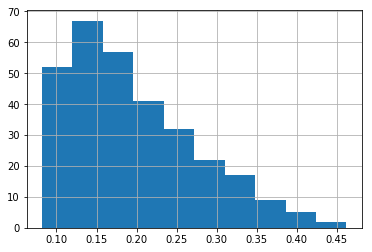

In [ ]:
qnet_dissonance_df.mean(axis=1).hist()

# Compute dissonance and random mask reconstruction for random samples

___________________________________________________
304 random samples computed
___________________________________________________


0         1         2  \
0    41.007514  0.219919  0.409027   
1    40.466687  0.222222  0.415831   
2    32.446426  0.221429  0.398686   
3    35.052732  0.216346  0.378016   
4    29.343099  0.218807  0.424375   
..         ...       ...       ...   
299  28.840746  0.216837  0.405624   
300  36.715760  0.218500  0.409547   
301  39.537220  0.219658  0.411876   
302  40.608053  0.218421  0.414117   
303  43.144611  0.215966  0.391760   

                                                     3  
0    [ptsd1, ptsd3, ptsd4, ptsd5, ptsd6, ptsd7, pts...  
1    [ptsd9, ptsd10, ptsd11, ptsd13, ptsd14, ptsd20...  
2    [ptsd3, ptsd5, ptsd7, ptsd11, ptsd12, ptsd14, ...  
3    [ptsd7, ptsd8, ptsd10, ptsd11, ptsd12, ptsd13,...  
4    [ptsd1, ptsd3, ptsd4, ptsd6, ptsd12, ptsd13, p...  
..                                                 ...  
299  [ptsd1, ptsd2, ptsd3, ptsd6, ptsd7, ptsd8, pts...  
300  [ptsd2, ptsd3, ptsd7, ptsd8, ptsd9, ptsd10, pt...  
301  [ptsd1, ptsd2, ptsd3, ptsd6, ptsd7, ptsd9, pts...  
302  [ptsd1, ptsd6, ptsd10, ptsd12, ptsd18, ptsd20,...  
303  [ptsd1, ptsd3, ptsd6, ptsd7, ptsd9, ptsd12, pt...  

[304 rows x 4 columns]

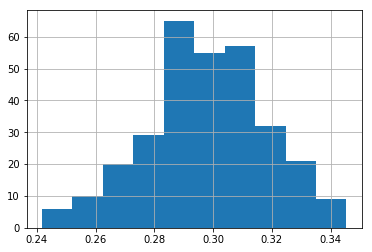

In [8]:
# computing dissonance of random samples
print("___________________________________________________")
n=304
random_samples = cognet_obj.random_sample(n=n)
print("{} random samples computed".format(n))
random_samples_strings = random_samples.values.astype(str)
results = []
for s in random_samples_strings:
    results.append(cognet_obj.dissonance(0, sample=s))
random_dissonance_df = pd.DataFrame(results)
random_dissonance_df.mean(axis=1).hist()

# computing random mask reconstruction of random samples
print("___________________________________________________")
random_samples_strings = random_samples.values.astype(str)
results = []
for s in random_samples_strings:
    results.append(cognet_obj.randomMaskReconstruction(sample=s, save_output=False))
random_randommask_df = pd.DataFrame(results)
random_randommask_df

# Comparing the dissonance distributions of Qnet vs Random Samples

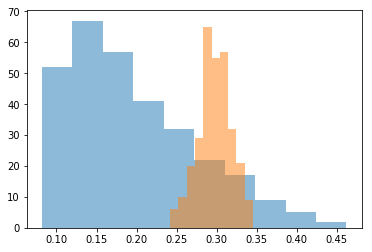

In [12]:
# comparing random and qnet sample dissonance distributions
plt.figure()
dissonance_df = pd.DataFrame(data=qnet_dissonance_df.mean(axis=1), columns=["Qnet"])
dissonance_df["random"] = random_dissonance_df.mean(axis=1)
plt.hist(dissonance_df["Qnet"], alpha=0.5, label="Qnet samples")
plt.hist(dissonance_df["random"], alpha=0.5, label="random samples")
plt.show()

# Comparing Positive vs Negative PTSD dissonance and reconstruction results

In [ ]:
# getting positive and negative PTSD samples and merging with dissonance and reconstruction results
PTSD_DATA = pd.read_csv("/project2/ishanu/NLS_DATA/PTSD_cognet_test.csv")[["PTSDDx"]]

PTSD_DATA["Mean Reconstruction"] = qnet_randommask_df["rederr"]
PTSD_DATA["Mean Dissonance"] = qnet_dissonance_df.mean(axis=1)

plt.style.use('fivethirtyeight')
PTSD_DATA.plot.scatter("Mean Dissonance", "Mean Reconstruction", c="PTSDDx")

In [99]:
# find confidence interval for negative PTSD samples
neg_mean = PTSD_DATA[PTSD_DATA["PTSDDx"] == 0]["Mean Dissonance"].mean()
neg_std = PTSD_DATA[PTSD_DATA["PTSDDx"] == 0]["Mean Dissonance"].std(ddof=1)
alpha_p1 = 0.1
alpha_p05 = 0.05
n_sided = 1 # 1-sided test
z_crit = stats.norm.ppf(1-alpha_p1/n_sided)
neg_threshold_p1=((-z_crit*neg_std)+neg_mean, (+z_crit*neg_std)+neg_mean)

z_crit = stats.norm.ppf(1-alpha_p05/n_sided)
neg_threshold_p05=((-z_crit*neg_std)+neg_mean, (+z_crit*neg_std)+neg_mean)

print('PTSD Negative Threshold (90%): ',neg_threshold_p1)
print('PTSD Negative (95%): ',neg_threshold_p05)

# find confidence interval for positive PTSD samples
pos_mean = PTSD_DATA[PTSD_DATA["PTSDDx"] == 1]["Mean Dissonance"].mean()
pos_std = PTSD_DATA[PTSD_DATA["PTSDDx"] == 1]["Mean Dissonance"].std(ddof=1)
alpha_p1 = 0.1
alpha_p05 = 0.05
n_sided = 1 # 1-sided test
z_crit = stats.norm.ppf(1-alpha_p1/n_sided)
pos_threshold_p1=((-z_crit*pos_std)+neg_mean, (+z_crit*pos_std)+pos_mean)

z_crit = stats.norm.ppf(1-alpha_p05/n_sided)
pos_threshold_p05=((-z_crit*pos_std)+pos_mean, (+z_crit*pos_std)+pos_mean)

# find confidence interval for positive PTSD samples
print('PTSD Positive Threshold (90%): ',pos_threshold_p1)
print('PTSD Positive (95%): ',pos_threshold_p05)


# confidence interval for all PTSD samples
all_mean = PTSD_DATA["Mean Dissonance"].mean()
all_std = PTSD_DATA["Mean Dissonance"].std(ddof=1)
alpha_p1 = 0.1
alpha_p05 = 0.05
n_sided = 1 # 1-sided test
z_crit = stats.norm.ppf(1-alpha_p1/n_sided)
all_threshold_p1=((-z_crit*all_std)+all_mean, (+z_crit*all_std)+all_mean)

z_crit = stats.norm.ppf(1-alpha_p05/n_sided)
all_threshold_p05=((-z_crit*all_std)+all_mean, (+z_crit*all_std)+all_mean)

print('All PTSD Threshold (90%): ',all_threshold_p1)
print('All PTSD (95%): ',all_threshold_p05)


PTSD Negative Threshold (90%):  (0.0872542035757383, 0.2518911524574446)
PTSD Negative (95%):  (0.06391805990404613, 0.27522729612913677)
PTSD Positive Threshold (90%):  (0.07251669573985073, 0.36096633938087386)
PTSD Positive (95%):  (0.13934035246495663, 0.38848036174330963)
All PTSD Threshold (90%):  (0.093934785598589, 0.29858583623412405)
All PTSD (95%):  (0.0649269210054165, 0.32759370082729655)


0.38848036174330963


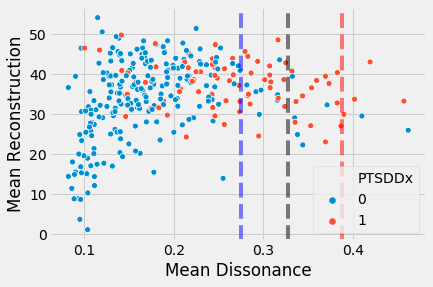

In [112]:
# plotting negative vs postive PTSD samples
import seaborn as sns
plt.gca().axes.get_xaxis().set_visible(True)
#random_mask_dissonance_df.plot.scatter("Mean Dissonance", "Mean Reconstruction", c="actual")
print(pos_threshold_p05[1])
plt.axvline(pos_threshold_p05[1], color="red", linestyle="--", alpha=.5)
plt.axvline(neg_threshold_p05[1], color="blue", linestyle="--", alpha=.5)
plt.axvline(all_threshold_p05[1], color="black", linestyle="--", alpha=.5)
sns.scatterplot(PTSD_DATA["Mean Dissonance"],
                PTSD_DATA["Mean Reconstruction"],
                hue=PTSD_DATA["PTSDDx"])

In [104]:
print("Number of negative PTSD results that are 'suspect' at alpha level of .05:", len(PTSD_DATA[(PTSD_DATA["Mean Dissonance"] >= neg_threshold_p05[1]) & (PTSD_DATA["PTSDDx"] == 0)]["Mean Dissonance"]))
print("Number of positive PTSD results that are 'suspect' at alpha level of .05:", len(PTSD_DATA[(PTSD_DATA["Mean Dissonance"] >= pos_threshold_p05[1]) & (PTSD_DATA["PTSDDx"] == 1)]["Mean Dissonance"]))

Number of negative PTSD results that are 'suspect' at alpha level of .05: 14
Number of positive PTSD results that are 'suspect' at alpha level of .05: 4


In [113]:
PTSD_DATA[(PTSD_DATA["Mean Dissonance"] >= neg_threshold_p05[1])]#[PTSD_DATA["PTSDDx"] == 1]

PTSDDx  Mean Reconstruction  Mean Dissonance
9         1            39.452127         0.369462
18        1            48.545839         0.316486
20        1            31.909471         0.323956
21        0            35.589638         0.291811
22        0            37.279897         0.281550
32        1            38.571410         0.301607
46        1            34.640084         0.343368
52        0            34.811713         0.316036
57        1            38.013921         0.308456
60        1            43.013907         0.419398
63        1            29.915861         0.390101
86        1            23.040904         0.369530
90        1            42.818289         0.325193
98        1            33.724088         0.402023
101       0            29.061513         0.335103
106       1            44.419026         0.282672
118       0            33.452264         0.315828
129       1            33.128175         0.336550
152       1            24.517871         0.294877
159       1            37.622267         0.373479
185       1            45.634698         0.279548
188       1            40.355069         0.382831
200       1            34.548599         0.282772
210       0            29.510644         0.410215
212       0            43.546484         0.318208
213       1            34.525326         0.343890
216       1            39.738602         0.307246
221       1            27.017382         0.386804
222       0            32.297571         0.371270
225       1            36.547336         0.353974
230       1            34.971282         0.283469
231       1            40.725680         0.332060
234       1            40.233175         0.286344
235       0            29.929963         0.295539
238       1            27.083384         0.352989
246       1            42.022193         0.307087
252       1            32.769730         0.382645
261       1            33.239286         0.457220
262       1            38.619077         0.322980
263       0            22.292087         0.344116
264       1            43.164422         0.293715
265       1            33.953013         0.316663
272       0            24.893099         0.338198
281       0            35.982828         0.297504
282       0            25.962316         0.462012
291       1            38.405300         0.359545
293       1            27.958768         0.335505
294       0            39.422515         0.332518
296       1            32.510264         0.285215
300       1            36.593131         0.307663

# Using Qsamples to generate random samples (Null Qsampling)

__________________________________________________
304 random samples computed


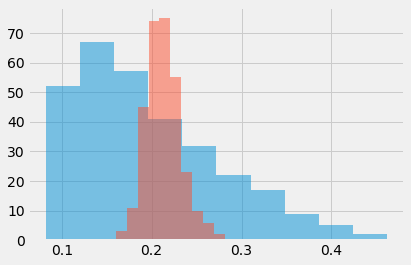

In [81]:
print("__________________________________________________")
null_array = np.zeros((len(features),), dtype=str)
nsamples = 304
print("{} random samples computed".format(nsamples))
qsamples = []
for n in range(nsamples):
    qsamples.append(cognet_obj.qsampling(null_array, 400))
qsamples

results = []
for s in qsamples:
    results.append(cognet_obj.dissonance(0, sample=s))
qrandom_dissonance_df = pd.DataFrame(results)

In [82]:
print("__________________________________________________")
null_array = np.zeros((len(features),), dtype=str)
nsamples = 304
print("{} random samples computed".format(nsamples))
qsamples = []
for n in range(nsamples):
    qsamples.append(cognet_obj.qsampling(null_array, 500))
qsamples

results = []
for s in qsamples:
    results.append(cognet_obj.dissonance(0, sample=s))
qrandom_dissonance_df = pd.DataFrame(results)

__________________________________________________
304 random samples computed


In [ ]:
# comparing qsampled random and qnet sample dissonance distributions
plt.figure()
qdissonance_df = pd.DataFrame(data=qnet_dissonance_df.mean(axis=1), columns=["Qnet"])
qdissonance_df["random"] = qrandom_dissonance_df.mean(axis=1)
plt.hist(qdissonance_df["Qnet"], alpha=0.5, label="Qnet samples")
plt.hist(qdissonance_df["random"], alpha=0.5, label="random samples")
plt.show()

In [25]:
qnet_randommask_df["rederr"].mean()

35.02638788602222

In [28]:
random_randommask_df[0].mean()

38.1130648637064

In [12]:
# find confidence interval for random samples
from scipy import stats
random_mean = random_dissonance_df.mean(axis=1).mean()
random_std = random_dissonance_df.mean(axis=1).std(ddof=1)
alpha_p1 = 0.1
alpha_p05 = 0.05
n_sided = 1 # 1-sided test
z_crit = stats.norm.ppf(1-alpha_p1/n_sided)
threshold_p1=(z_crit*random_std)+random_mean

z_crit = stats.norm.ppf(1-alpha_p05/n_sided)
threshold_p05=(z_crit*random_std)+random_mean

print('Random Sample Thershold (90%): ',threshold_p1)
print('Random Sample Thershold (95%): ',threshold_p05)

# find confidence interval for qnet samples
qnet_mean = qnet_dissonance_df.mean(axis=1).mean()
qnet_std = qnet_dissonance_df.mean(axis=1).std(ddof=1)
alpha_p1 = 0.1
alpha_p05 = 0.05
n_sided = 1 # 1-sided test
z_crit = stats.norm.ppf(1-alpha_p1/n_sided)
threshold_p1=(z_crit*qnet_std)+qnet_mean

z_crit = stats.norm.ppf(1-alpha_p05/n_sided)
threshold_p05=(z_crit*qnet_std)+qnet_mean

print('Qnet Thershold (90%): ',threshold_p1)
print('Qnet Thershold (95%): ',threshold_p05)

Random Sample Thershold (90%):  0.323930021895188
Random Sample Thershold (95%):  0.33153236597733904
Qnet Thershold (90%):  0.29858583623412405
Qnet Thershold (95%):  0.32759370082729655


In [22]:
# combine the random mask reconstruction dfs
qnet_randommask_df1 = qnet_randommask_df[["rederr"]]
random_randommask_df1 = random_randommask_df[[0]]
random_randommask_df1.columns=["rederr"]
qnet_randommask_df1["actual"] = 1
random_randommask_df1["actual"] = 0
random_mask_df = pd.concat([qnet_randommask_df1, random_randommask_df1], ignore_index=True)

In [23]:
# combine the dissonance dfs
dissonance_df = pd.DataFrame(data=qnet_dissonance_df.mean(axis=1), columns=["Mean Dissonance"])
dissonance_df["actual"] = 1
dissonance_df1 = pd.DataFrame(data=random_dissonance_df.mean(axis=1), columns=["Mean Dissonance"])
dissonance_df1["actual"] = 0
dissonance_df = pd.concat([dissonance_df, dissonance_df1], ignore_index=True)

In [27]:
# combine dissonance and recon dfs
random_mask_dissonance_df = dissonance_df
random_mask_dissonance_df["Mean Reconstruction"] = random_mask_df["rederr"]
random_mask_dissonance_df

Mean Dissonance  actual  Mean Reconstruction
0           0.185657       1            33.270891
1           0.153450       1            37.695298
2           0.222102       1            38.887323
3           0.138878       1            41.820925
4           0.146156       1            38.100904
..               ...     ...                  ...
603         0.326093       0            41.100344
604         0.288748       0            37.927735
605         0.304060       0            38.349455
606         0.276205       0            27.842122
607         0.329974       0            46.035389

[608 rows x 3 columns]

In [ ]:
PTSD_data = pd.read_csv("/project2/ishanu/NLS_DATA/PTSD_cognet_test.csv")
PTSD_data[[1]]

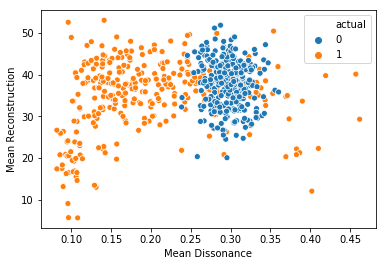

In [32]:
# plot dissonance vs recon
import seaborn as sns
plt.gca().axes.get_xaxis().set_visible(True)
#random_mask_dissonance_df.plot.scatter("Mean Dissonance", "Mean Reconstruction", c="actual")
sns.scatterplot(random_mask_dissonance_df["Mean Dissonance"],
                random_mask_dissonance_df["Mean Reconstruction"],
                hue=random_mask_dissonance_df["actual"])

In [17]:
return_df = pd.DataFrame()
for col in cognet_obj.samples.columns:
    return_df[col] = cognet_obj.samples[col].sample(n=1, replace=True).values
return_df

ptsd1 ptsd2 ptsd3 ptsd4 ptsd5 ptsd6 ptsd7 ptsd8 ptsd9 ptsd10  ... ptsd202  \
0     2     1     1     1     4     3     1     3     1      1  ...       3   

  ptsd203 ptsd204 ptsd205 ptsd206 ptsd207 ptsd208 ptsd209 ptsd210 ptsd211  
0       2       1       2       4       1       3       1       2       5  

[1 rows x 211 columns]

In [30]:
cognet_obj.samples[cognet_obj.samples.index.duplicated()]

Empty DataFrame
Columns: [ptsd1, ptsd2, ptsd3, ptsd4, ptsd5, ptsd6, ptsd7, ptsd8, ptsd9, ptsd10, ptsd11, ptsd12, ptsd13, ptsd14, ptsd15, ptsd16, ptsd17, ptsd18, ptsd19, ptsd20, ptsd21, ptsd22, ptsd23, ptsd24, ptsd25, ptsd26, ptsd27, ptsd28, ptsd29, ptsd30, ptsd31, ptsd32, ptsd33, ptsd34, ptsd35, ptsd36, ptsd37, ptsd38, ptsd39, ptsd40, ptsd41, ptsd42, ptsd43, ptsd44, ptsd45, ptsd46, ptsd47, ptsd48, ptsd49, ptsd50, ptsd51, ptsd52, ptsd53, ptsd54, ptsd55, ptsd56, ptsd57, ptsd58, ptsd59, ptsd60, ptsd61, ptsd62, ptsd63, ptsd64, ptsd65, ptsd66, ptsd67, ptsd68, ptsd69, ptsd70, ptsd71, ptsd72, ptsd73, ptsd74, ptsd75, ptsd76, ptsd77, ptsd78, ptsd79, ptsd80, ptsd81, ptsd82, ptsd83, ptsd84, ptsd85, ptsd86, ptsd87, ptsd88, ptsd89, ptsd90, ptsd91, ptsd92, ptsd93, ptsd94, ptsd95, ptsd96, ptsd97, ptsd98, ptsd99, ptsd100, ...]
Index: []

[0 rows x 211 columns]

In [ ]:
# samples = pd.read_csv("PTSD_cognet_test.csv")
# samples = samples.drop(['record_id', 'PTSDDx'], axis=1)
# samples.to_csv("PTSD_cognet_test_processed.csv", index=False)
# samples = pd.read_csv("PTSD_cognet_test_processed.csv")
# samples